In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

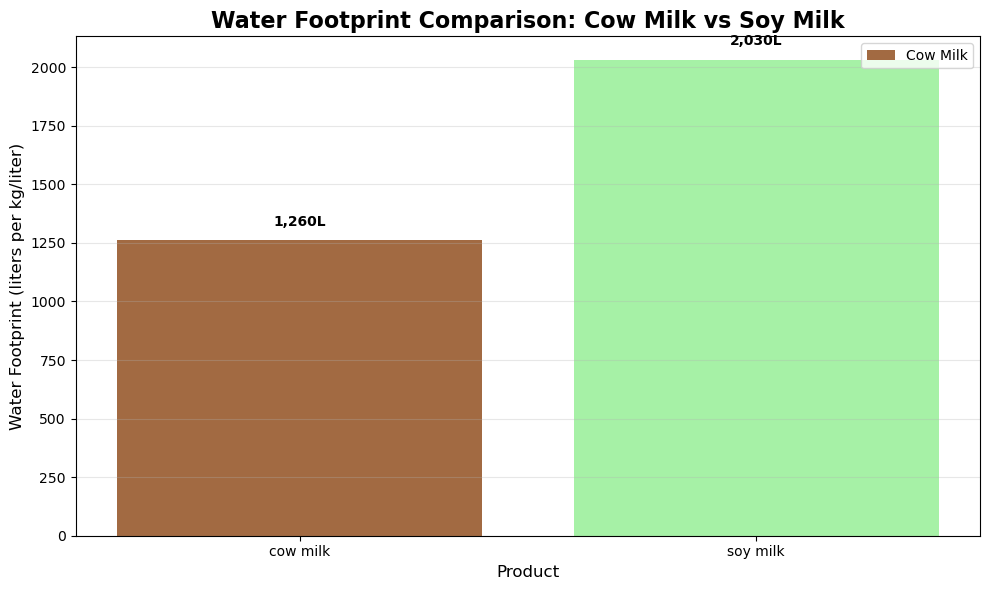

In [3]:
df = pd.read_csv(r'site/final_data/game_data.csv')

# Filter for cow milk and soy milk
milk_data = df[df['AGROVOC_label'].isin(['cow milk', 'soy milk'])].copy()

# Extract the relevant columns
products = milk_data['AGROVOC_label'].tolist()
water_footprint = milk_data['Water Footprint liters (water/kg o liter)'].tolist()

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(products, water_footprint, color=['#8B4513', '#90EE90'], alpha=0.8)

# Customize the chart
plt.title('Water Footprint Comparison: Cow Milk vs Soy Milk', fontsize=16, fontweight='bold')
plt.xlabel('Product', fontsize=12)
plt.ylabel('Water Footprint (liters per kg/liter)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, value in zip(bars, water_footprint):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:,.0f}L', ha='center', va='bottom', fontweight='bold')

# Add colors legend
plt.legend(['Cow Milk', 'Soy Milk'], loc='upper right')

# Improve layout
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_products(product1, product2, csv_file= r'site/final_data/game_data.csv'):
    """
    Compare two products in terms of water usage and CO2 production.
    
    Parameters:
    product1 (str): Name of the first product (as it appears in AGROVOC_label column)
    product2 (str): Name of the second product (as it appears in AGROVOC_label column)
    csv_file (str): Path to the CSV file containing the data
    """
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter for the specified products
    product_data = df[df['AGROVOC_label'].isin([product1, product2])].copy()
    
    # Check if both products exist in the dataset
    if len(product_data) != 2:
        available_products = df['AGROVOC_label'].tolist()
        print(f"Error: One or both products not found in dataset.")
        print(f"Available products: {available_products}")
        return
    
    # Extract data
    products = product_data['AGROVOC_label'].tolist()
    water_footprint = product_data['Water Footprint liters (water/kg o liter)'].tolist()
    co2_footprint = product_data['Carbon Footprint (g CO2eq/g o cc)'].tolist()
    
    # Check for missing data
    if any(pd.isna(water_footprint)) or any(pd.isna(co2_footprint)):
        print("Warning: Some data is missing for the selected products.")
        print(f"Water footprint data: {water_footprint}")
        print(f"CO2 footprint data: {co2_footprint}")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for consistency
    colors = ['#FF6B6B', "#2BCA25"]
    
    # Water Usage Comparison
    bars1 = ax1.bar(products, water_footprint, color=colors, alpha=0.8)
    ax1.set_title(f'Water Footprint Comparison:\n{product1} vs {product2}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Product', fontsize=12)
    ax1.set_ylabel('Water Footprint (liters per kg/liter)', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on water chart
    for bar, value in zip(bars1, water_footprint):
        if not pd.isna(value):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(water_footprint)*0.02, 
                     f'{value:,.0f}L', ha='center', va='bottom', fontweight='bold')
    
    # CO2 Production Comparison
    bars2 = ax2.bar(products, co2_footprint, color=colors, alpha=0.8)
    ax2.set_title(f'Carbon Footprint Comparison:\n{product1} vs {product2}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Product', fontsize=12)
    ax2.set_ylabel('Carbon Footprint (g CO2eq/g)', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on CO2 chart
    for bar, value in zip(bars2, co2_footprint):
        if not pd.isna(value):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(co2_footprint)*0.02, 
                     f'{value:.3f}g', ha='center', va='bottom', fontweight='bold')
    
    # Improve layout
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("="*60)
    print(f"COMPARISON RESULTS: {product1} vs {product2}")
    print("="*60)
    


# Example usage:
# Compare cow milk and soy milk


# You can easily compare any other products by changing the function call:
# compare_products('beef', 'chicken meat')
# compare_products('apples', 'bananas')
# compare_products('coffee', 'soft drinks')

# To see all available products:
def show_available_products(csv_file='game_data.csv'):
    """Display all available products in the dataset."""
    df = pd.read_csv(csv_file)
    products = sorted(df['AGROVOC_label'].tolist())
    print("Available products for comparison:")
    for i, product in enumerate(products, 1):
        print(f"{i:2d}. {product}")

# Uncomment the line below to see all available products:
# show_available_products()

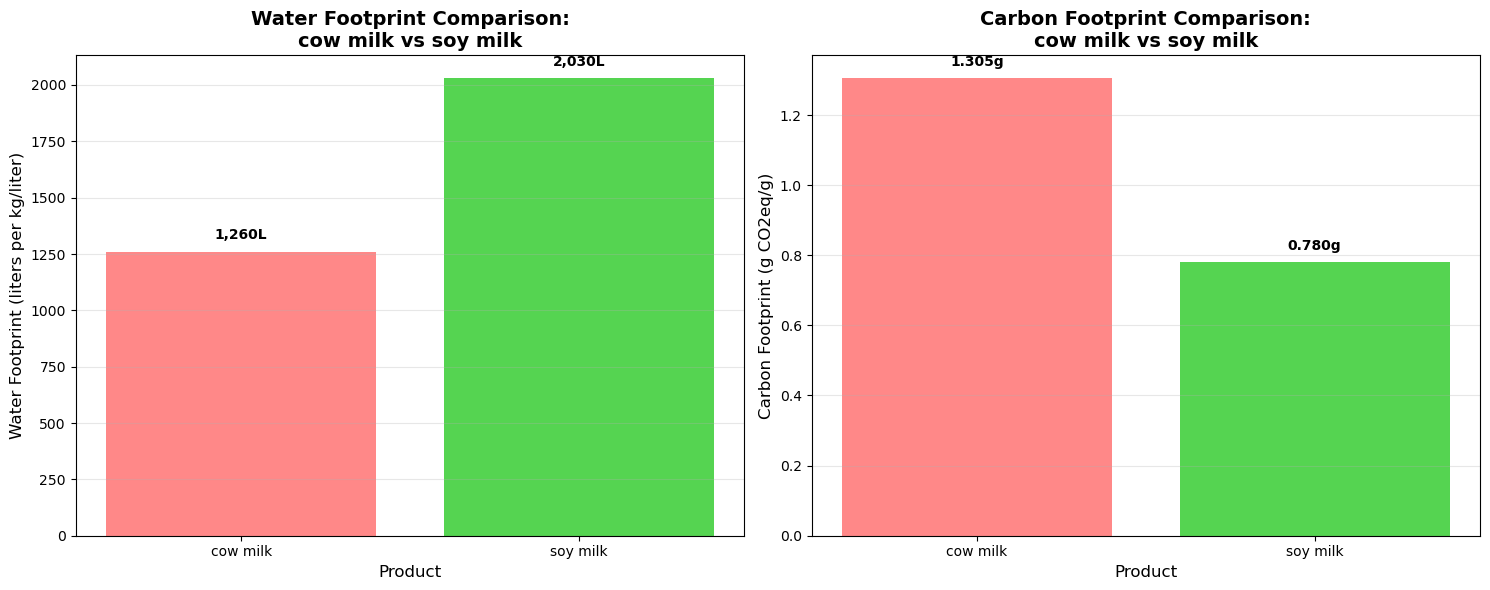

COMPARISON RESULTS: cow milk vs soy milk

WATER FOOTPRINT:
cow milk: 1,260 liters per kg/liter
soy milk: 2,030 liters per kg/liter
Difference: 770 liters per kg/liter
soy milk uses 1.6x more water than cow milk

CARBON FOOTPRINT:
cow milk: 1.305 g CO2eq/g
soy milk: 0.780 g CO2eq/g
Difference: 0.525 g CO2eq/g
cow milk produces 1.7x more CO2 than soy milk


In [6]:
compare_products('cow milk', 'soy milk')